In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pinocchio as pin
from src.forward_kinematics import ForwardKinematic
from src.urdf_parser import Link
from utils.visualization import plot_3d_ellipsoid_from_covariance, visualize_robot

In [5]:
fk = ForwardKinematic(
    urdf_file='franka_description/urdf/panda_no_gripper.urdf',
    components_per_link=7)
config = pin.neutral(fk.model)
config = pin.randomConfiguration(fk.model)
_ = fk(config, np.zeros_like(config), derivation_order=0)

%matplotlib widget

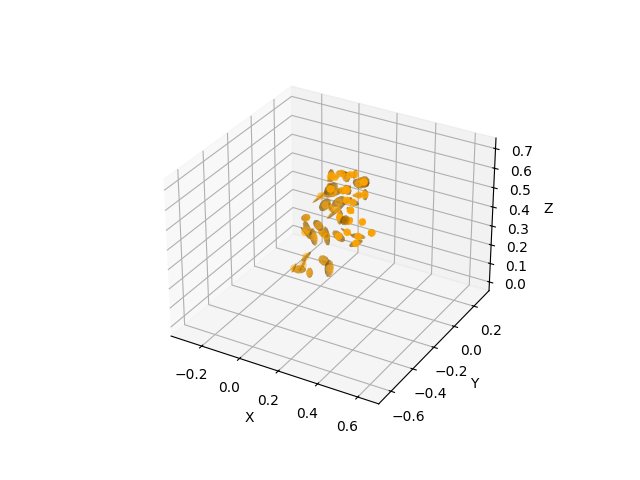

In [6]:
visualize_robot(fk=fk, obstacle=None, color='orange')
plt.show()

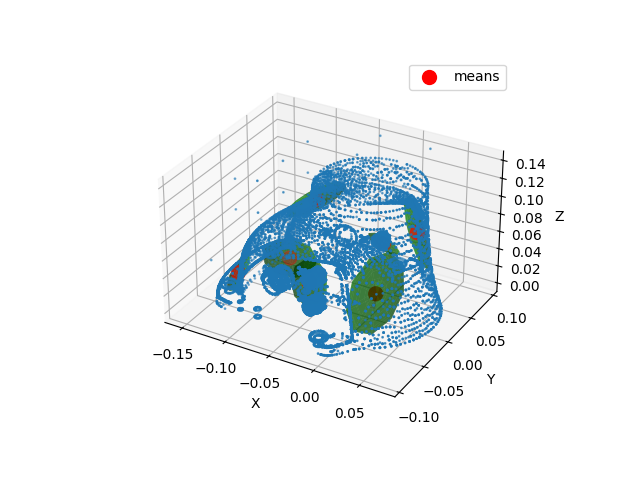

In [4]:
link = fk.links[0]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(link.points[:, 0], link.points[:, 1], link.points[:, 2], s=1)
ax.scatter(link.means[:, 0], link.means[:, 1], link.means[:, 2], s=100, c='r', label='means')
for i in range(link.covs.shape[0]):
    ax.set_aspect('equal')
    plot_3d_ellipsoid_from_covariance(link.covs[i], center=link.means[i], ax=ax, color='green')
plt.legend()
plt.show()